##### Precily vs forge comparison

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
from forge_class_instance3 import FORGE
%matplotlib inline

2026-01-29 11:06:53.855613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/sreeramp/miniconda3/envs/precily_tf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
forge_model = FORGE.load_forge(path='/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Models/optuna_models/ERLOTINIB_EGFR_forgeModel_optuna100.pkl')

In [3]:
forge_model.__getstate__().keys()

dict_keys(['exp_path', 'dep_path', 'ic50_path', 'drug', 'target', 'test_cellLines', 'train_cellLines', 'mean_dep', 'mean_ic50', 'training_cv_splits', 'hcg_list', 'exp_hcg', 'mean_exp', 'std_exp', 'W', 'hD', 'hI'])

In [4]:
# get forge predictions for test cell lines
exp_data = pd.read_csv(forge_model.exp_path, header=0, index_col=0)
exp_test = (exp_data.loc[forge_model.test_cellLines, forge_model.hcg_list] - forge_model.mean_exp) / forge_model.std_exp
exp_test.shape

(137, 201)

In [5]:
forge_pred = exp_test @ forge_model.W @ forge_model.hI
forge_pred

,0
StrippedCellLineName,
HCC33,-3.206570
G401,-0.431058
YH13,1.491560
SKLMS1,2.273559
SUDHL10,-0.961441
...,...
KELLY,0.163829
HUH1,1.010974
HCC366,-0.150954


In [6]:
full_chemberta_data = pd.read_parquet(
    '../Data/scaled_hv_pes_chemberta.parquet')

In [7]:
len([cl for cl in full_chemberta_data['cell_line'].unique()
     if cl in forge_model.test_cellLines])


137

In [8]:
erlo_test_data = full_chemberta_data.loc[
    (full_chemberta_data['cell_line'].isin(forge_model.test_cellLines)) &
    (full_chemberta_data['drug_name'].str.upper().str.strip() == 'ERLOTINIB'),
    :
]

erlo_test_data.shape

(137, 2022)

In [9]:
erlo_test_data.set_index('cell_line', inplace=True)

In [10]:
erlo_test_data.head()

,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,TPSA,FractionCSP3,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,...,WP_UDPDERIVED_SUGARS_SYNTHESIS_IN_FIBROBLASTS,WP_VALPROIC_ACID_PATHWAY,WP_VEDOLIZUMAB_THERAPY_FOR_INFLAMMATORY_BOWEL_DISEASE,WP_VISUAL_CYCLE,WP_VITAMIN_A1_AND_A5X_PATHWAYS,WP_VITAMIN_B6DEPENDENT_AND_RESPONSIVE_DISORDERS,WP_WNTBETACATENIN_SIGNALING_INHIBITORS_IN_CURRENT_AND_PAST_CLINICAL_TRIALS,WP_WNT_SIGNALING_IN_ADULT_HIPPOCAMPAL_NEUROGENESIS,scaled_ic50,drug_name
cell_line,,,,,,,,,,,,,,,,,,,,,
22RV1,-0.398033,-0.387198,-0.398172,-0.28,-0.522694,-0.242424,0.0,0.0,0.0,-0.5,...,-0.423827,1.040696,-1.528110,0.282063,-0.697053,0.759775,-0.870303,0.689314,0.405680,ERLOTINIB
42MGBA,-0.398033,-0.387198,-0.398172,-0.28,-0.522694,-0.242424,0.0,0.0,0.0,-0.5,...,0.453542,-0.384049,0.515939,-0.274552,0.273584,-0.163485,-0.057254,0.016049,0.526810,ERLOTINIB
769P,-0.398033,-0.387198,-0.398172,-0.28,-0.522694,-0.242424,0.0,0.0,0.0,-0.5,...,0.817489,0.594624,0.282751,-0.511184,-0.322653,0.035031,-0.926242,-0.563760,0.112823,ERLOTINIB
8505C,-0.398033,-0.387198,-0.398172,-0.28,-0.522694,-0.242424,0.0,0.0,0.0,-0.5,...,-0.039655,-0.848419,0.127736,-0.694490,0.440525,0.039210,0.259710,-0.280235,0.831033,ERLOTINIB
A2058,-0.398033,-0.387198,-0.398172,-0.28,-0.522694,-0.242424,0.0,0.0,0.0,-0.5,...,0.544537,-0.801677,0.163931,-0.178015,0.467905,-0.630898,0.492900,0.281221,0.279338,ERLOTINIB


In [11]:
y_test_df = erlo_test_data['scaled_ic50']
erlo_test_data.drop(columns = ['drug_name', 'scaled_ic50'], inplace=True)

/tmp/ipykernel_2524449/3512301021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  erlo_test_data.drop(columns = ['drug_name', 'scaled_ic50'], inplace=True)


In [12]:
erlo_test_data.head()

,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,TPSA,FractionCSP3,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,...,WP_TYPE_I_COLLAGEN_SYNTHESIS_IN_THE_CONTEXT_OF_OSTEOGENESIS_IMPERFECTA,WP_TYPE_I_INTERFERON_INDUCTION_AND_SIGNALING_DURING_SARSCOV2_INFECTION,WP_UDPDERIVED_SUGARS_SYNTHESIS_IN_FIBROBLASTS,WP_VALPROIC_ACID_PATHWAY,WP_VEDOLIZUMAB_THERAPY_FOR_INFLAMMATORY_BOWEL_DISEASE,WP_VISUAL_CYCLE,WP_VITAMIN_A1_AND_A5X_PATHWAYS,WP_VITAMIN_B6DEPENDENT_AND_RESPONSIVE_DISORDERS,WP_WNTBETACATENIN_SIGNALING_INHIBITORS_IN_CURRENT_AND_PAST_CLINICAL_TRIALS,WP_WNT_SIGNALING_IN_ADULT_HIPPOCAMPAL_NEUROGENESIS
cell_line,,,,,,,,,,,,,,,,,,,,,
22RV1,-0.398033,-0.387198,-0.398172,-0.28,-0.522694,-0.242424,0.0,0.0,0.0,-0.5,...,-0.474864,-1.016975,-0.423827,1.040696,-1.528110,0.282063,-0.697053,0.759775,-0.870303,0.689314
42MGBA,-0.398033,-0.387198,-0.398172,-0.28,-0.522694,-0.242424,0.0,0.0,0.0,-0.5,...,1.160365,0.126007,0.453542,-0.384049,0.515939,-0.274552,0.273584,-0.163485,-0.057254,0.016049
769P,-0.398033,-0.387198,-0.398172,-0.28,-0.522694,-0.242424,0.0,0.0,0.0,-0.5,...,-0.171212,0.275501,0.817489,0.594624,0.282751,-0.511184,-0.322653,0.035031,-0.926242,-0.563760
8505C,-0.398033,-0.387198,-0.398172,-0.28,-0.522694,-0.242424,0.0,0.0,0.0,-0.5,...,0.633552,-0.223886,-0.039655,-0.848419,0.127736,-0.694490,0.440525,0.039210,0.259710,-0.280235
A2058,-0.398033,-0.387198,-0.398172,-0.28,-0.522694,-0.242424,0.0,0.0,0.0,-0.5,...,0.656103,-0.785551,0.544537,-0.801677,0.163931,-0.178015,0.467905,-0.630898,0.492900,0.281221


In [13]:
# get 5-fold predictions from precily
precily_model_dir = '/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Models/precily_tf_models_unscaled'
pred_vals = {}
for i in range(1,6):
    model_path = os.path.join(precily_model_dir, f"precily_tf_full_train_fold{str(i)}.hdf5")
    
    if os.path.exists(model_path):
        # print('True')
        precily_model = tf.keras.models.load_model(model_path, compile=False)
        test_preds_fold = precily_model.predict(erlo_test_data)
        pred_vals[f'fold{str(i)}'] = test_preds_fold.ravel()
        

I0000 00:00:1769665030.839997 2524449 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46660 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6
2026-01-29 11:07:11.927791: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fe1ec003a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-29 11:07:11.927831: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2026-01-29 11:07:11.938319: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-29 11:07:11.960039: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800
2026-01-29 11:07:11.967848: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered ou

1/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step

I0000 00:00:1769665034.026836 2524842 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2026-01-29 11:07:14.430860: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 4 bytes spill stores, 4 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 347ms/step


2026-01-29 11:07:15.707543: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-29 11:07:15.959246: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 16 bytes spill stores, 16 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step


2026-01-29 11:07:18.172979: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fe76c9bbac0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step


2026-01-29 11:07:22.228132: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-29 11:07:22.500655: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 16 bytes spill stores, 16 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step


In [14]:
precily_preds = pd.DataFrame(pred_vals)
precily_preds.head()

,fold1,fold2,fold3,fold4,fold5
0,5.166476,5.338706,4.620931,5.144332,6.905871
1,5.045162,5.285840,7.642074,6.158267,5.518125
2,7.564632,6.648540,6.278824,7.989124,7.888905
3,6.719980,5.486954,6.238741,5.327294,6.101460
4,6.856010,6.513320,6.165352,6.210270,6.548479


In [15]:
# Mean across folds (row-wise)
precily_preds['mean_pred'] = precily_preds.mean(axis=1)

# Make sure lengths match before assigning
assert len(precily_preds) == len(forge_model.test_cellLines), \
    "Row count mismatch between precily_preds and test_cellLines"

# Assign cell lines
precily_preds['cell_line'] = erlo_test_data.index

precily_preds.set_index('cell_line', inplace=True)
# Add forge predictions (must be same length or same index)
precily_preds['forge_preds'] = forge_pred


In [16]:
precily_preds.head()

,fold1,fold2,fold3,fold4,fold5,mean_pred,forge_preds
cell_line,,,,,,,
22RV1,5.166476,5.338706,4.620931,5.144332,6.905871,5.435264,0.292963
42MGBA,5.045162,5.285840,7.642074,6.158267,5.518125,5.929893,1.702960
769P,7.564632,6.648540,6.278824,7.989124,7.888905,7.274005,0.410624
8505C,6.719980,5.486954,6.238741,5.327294,6.101460,5.974885,0.759682
A2058,6.856010,6.513320,6.165352,6.210270,6.548479,6.458687,0.245622


In [17]:
y_test_df

cell_line
22RV1      0.405680
42MGBA     0.526810
769P       0.112823
8505C      0.831033
A2058      0.279338
             ...   
UBLC1     -2.979743
UWB1289   -0.992367
WSUNHL    -0.758854
YD15      -1.514131
YH13       0.452202
Name: scaled_ic50, Length: 137, dtype: float64

In [18]:
# y_test_df.set_index('cell_line', inplace=True)
precily_preds['scaled_ic50'] = y_test_df

In [19]:
precily_preds['forge_raw_pred'] = precily_preds['forge_preds'] + forge_model.mean_ic50

In [20]:
precily_preds.head()

,fold1,fold2,fold3,fold4,fold5,mean_pred,forge_preds,scaled_ic50,forge_raw_pred
cell_line,,,,,,,,,
22RV1,5.166476,5.338706,4.620931,5.144332,6.905871,5.435264,0.292963,0.405680,5.594028
42MGBA,5.045162,5.285840,7.642074,6.158267,5.518125,5.929893,1.702960,0.526810,7.004025
769P,7.564632,6.648540,6.278824,7.989124,7.888905,7.274005,0.410624,0.112823,5.711689
8505C,6.719980,5.486954,6.238741,5.327294,6.101460,5.974885,0.759682,0.831033,6.060747
A2058,6.856010,6.513320,6.165352,6.210270,6.548479,6.458687,0.245622,0.279338,5.546687


In [21]:
from scipy.stats import pearsonr, spearmanr

x = precily_preds['scaled_ic50']
y = precily_preds['mean_pred']

r, pval = pearsonr(x, y)
print(f"Pearson r = {r:.4f}, p-value = {pval:.3e}")
rho, pval = spearmanr(x, y)
print(f"Spearman rho = {rho:.4f}, p-value = {pval:.3e}")

Pearson r = 0.3332, p-value = 6.937e-05
Spearman rho = 0.3947, p-value = 1.819e-06


<Axes: xlabel='mean_pred', ylabel='scaled_ic50'>

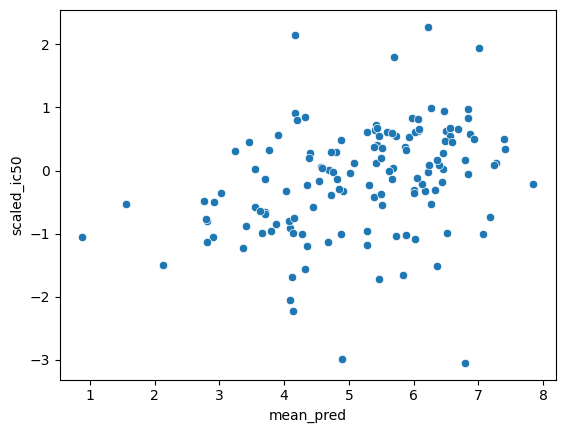

In [22]:
sns.scatterplot(data=precily_preds, x = 'mean_pred', y='scaled_ic50')

In [23]:
ic50_data = pd.read_csv(forge_model.ic50_path, header = 0, index_col = 0)
ic50_data = ic50_data.T
erlo_test_ic50 = ic50_data.loc[forge_model.test_cellLines, 'ERLOTINIB']
erlo_test_ic50.shape


(137,)

In [24]:
ic50_data.head()

drug,ABIRATERONE,ABT-751,AFATINIB,AFURESERTIB,ALECTINIB,ALISERTIB,ALPELISIB,ALVOCIDIB,AMG-319,AMUVATINIB,...,VELIPARIB,VENETOCLAX,VINBLASTINE,VINCRISTINE,VINORELBINE,VISMODEGIB,VORINOSTAT,VOXTALISIB,ZIBOTENTAN,ZILEUTON
1321N1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,NaN,NaN,1.47000,NaN,NaN,3.18810,2.73910,-2.49402,NaN,NaN,...,7.57654,8.44648,NaN,-0.795137,NaN,NaN,2.770280,NaN,NaN,NaN
22RV1,NaN,NaN,2.80303,2.11144,4.80222,10.52470,3.52965,NaN,6.39615,4.37605,...,6.82060,3.05369,-6.48795,-3.765350,-6.55542,4.58268,1.086850,5.41142,7.35143,NaN
2313287,NaN,NaN,1.54454,1.40029,3.94753,4.46529,2.36674,NaN,4.35094,5.92903,...,6.74127,1.50728,-6.90162,-4.108140,-7.56164,5.42715,1.264830,4.18544,6.15199,NaN
253J,NaN,NaN,0.28527,NaN,NaN,4.87433,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.163836,NaN,NaN,0.940899,NaN,NaN,NaN


In [25]:
precily_preds['actual_IC50'] = erlo_test_ic50

In [34]:
x = precily_preds['forge_raw_pred']
y = precily_preds['mean_pred']

r, pval = pearsonr(x, y)
print(f"Pearson r = {r:.4f}, p-value = {pval:.3e}")
rho, pval = spearmanr(x, y)
print(f"Spearman rho = {rho:.4f}, p-value = {pval:.3e}")

Pearson r = 0.6840, p-value = 3.215e-20
Spearman rho = 0.6840, p-value = 3.172e-20


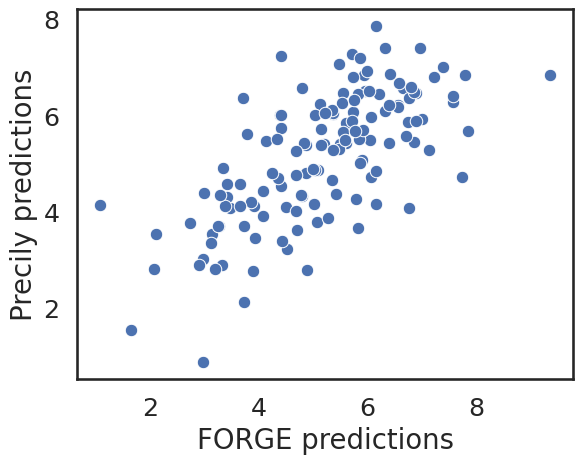

In [35]:
sns.scatterplot(x=x, y=y)
plt.xlabel('FORGE predictions')
plt.ylabel('Precily predictions')
plt.show()

In [28]:
%pip install lifelines


Note: you may need to restart the kernel to use updated packages.


In [29]:
from lifelines.utils import concordance_index

In [30]:
from sklearn.metrics import r2_score,  mean_absolute_error

In [31]:
from matplotlib import rcParams
# --- Matplotlib settings
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'DejaVu Sans'

sns.set(style="white", context="talk", font_scale=1.1)

In [32]:
# === Plot aesthetics
sns.set(style="white", context="talk", font_scale=1.1)

def annotate_and_regress(ax, x, y, title, xlabel, ylabel):
    x = x.flatten()
    y = y.flatten()

    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    r2 = r2_score(x, y)
    mae = mean_absolute_error(x, y)
    ci = concordance_index(x, y)
    
    sns.regplot(
        x=x,
        y=y,
        ax=ax,
        color='darkslategrey',  # Line + CI color
        scatter_kws={'s': 40, 'alpha': 1, 'color': 'seagreen','rasterized': True, 'edgecolors': 'black', 'linewidths': 0.1},
        line_kws={'color': 'darkslategrey'},
        ci=100
    )

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    metrics = (
        f"Pearson r   = {pearson_corr:.2f}\n"
        f"Spearman ρ  = {spearman_corr:.2f}\n"
        f"R² Score    = {r2:.2f}\n"
        f"MAE         = {mae:.2f}\n"
        f"C-Index     = {ci:.2f}"
    )

    ax.text(
        0.05, 0.95, metrics,
        transform=ax.transAxes,
        fontsize=11,
        va="top", ha='left',
        bbox=dict(boxstyle="round", fc="white", ec="grey", alpha=0.9)
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both', which='major', labelsize=12)

/tmp/ipykernel_2524449/31081120.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x=x.ravel(),
/tmp/ipykernel_2524449/31081120.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y=y.ravel(),


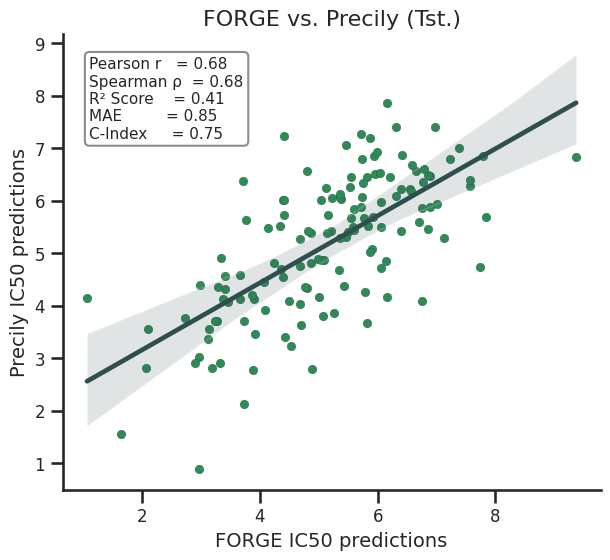

In [36]:
fig1, ax1 = plt.subplots(figsize=(6.5, 6))
annotate_and_regress(
    ax1,
    x=x.ravel(),
    y=y.ravel(),
    title = "FORGE vs. Precily (Tst.)",
    xlabel="FORGE IC50 predictions",
    ylabel="Precily IC50 predictions"
)
plt.tight_layout()
fig1.savefig("/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Figs/pprecily_vs_forge_testPreds.pdf", dpi=300, bbox_inches='tight')  # 💾 Save the figure
plt.show()